# Problem 2: MNIST Image Classification

In [2]:
%matplotlib inline
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.image as mpimg
from tqdm import tqdm
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier
from itertools import product
from scipy.stats import norm

In [3]:
mndata = MNIST('./data/mnist/')

In [4]:
def showImage(pixels, label, shape = (28, 28)):
    pixels = np.array(pixels, dtype='uint8')
    pixels = pixels.reshape(shape)
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [72]:
def saveImage(pixels, label, shape = (28, 28)):
    pixels = np.array(pixels, dtype='uint8')
    pixels = pixels.reshape(shape)
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.savefig(f'mean-{label}.jpg')

## Part 2A: MNIST using naive Bayes

### Using Normal distribution and untouched images

In [5]:
def aggregateImagesByNumber(images, labels): 
    numberToImages = {}
    for index in range(len(images)):
        label = labels[index]
        if(label not in numberToImages):
            numberToImages[label] = []
        numberToImages[label].append(images[index])
    return numberToImages

In [6]:
def calculateMeanAndVar(data):
    results = []
    for item in zip(*data):
        meanVar = (np.nanmean(item), np.nanvar(item))
        results.append(meanVar)
    return results

In [7]:
def calculateMeanAndVarForNumbers(dataByClasses):
    results = {}
    for classValue, values in dataByClasses.items():
        results[classValue] = calculateMeanAndVar(values)
    return results

In [8]:
def calculateProbability(x, mean, var):
    p = 1/(np.sqrt(2*np.pi*var)) * np.exp((-(x-mean)**2)/(2*var))
    return p

In [9]:
def calculateProbabilitiesForNumbers(dataByClasses, imagePixels):
    classProbabilities = {}
    for label, images in dataByClasses.items():
        classProbabilities[label] = 1
        for i in range(len(images)):
            mean, var = images[i]
            inputV = imagePixels[i]
            prob = calculateProbability(inputV, mean, var)
            classProbabilities[label] *= prob
    return classProbabilities

In [10]:
def getPrediction(numberSummaries, imagePixels):
    numberProbabilities = calculateProbabilitiesForNumbers(numberSummaries, imagePixels)
    predictedLabel, bestProb = None, -1
    for label, prob in numberProbabilities.items():
        if predictedLabel is None or prob > bestProb:
            predictedLabel = label
            bestProb = prob
    return predictedLabel

In [11]:
def getPredictionsForTestNumbers(numberSummaries, testImages):
    predictions = []
    for imagePixels in tqdm(testImages):
        prediction = getPrediction(numberSummaries, imagePixels)
        predictions.append(prediction)
    return predictions

In [12]:
def getAccuracy(predictions, testData, testLabels):
    accurate = 0
    rows_in_test_set = len(testData)
    for index in range(rows_in_test_set):
        if predictions[index] == testLabels[index]:
            accurate += 1
    return (accurate / rows_in_test_set) * 100

In [13]:
def thresholdOriginalImages(images):
    threshold, upper, lower = 127, 1, 0
    return np.where(np.array(images)>threshold, upper, lower)

In [14]:
def thresholdScaledImages(imagePixels):
    a = imagePixels.copy()
    grey = a[a > 0]
    mid = np.sum(grey) / len(grey)
    return np.where(np.array(a)>mid, 1, 0)

In [15]:
def resizeImage(imagePixels, size):
    xmax, ymax = np.max(np.where(imagePixels!=0), 1)
    xmin, ymin = np.min(np.where(imagePixels!=0), 1)
    bounding = imagePixels[xmin:xmax,ymin:ymax]
    resized = resize(bounding, size, mode='constant')
    return resized

In [65]:
def plotMeanNumbers(classSummary):
    for number, data in classSummary.items():
        pixels = thresholdScaledImages(np.array([mean for mean, var in data]))
        saveImage(pixels, number)


In [66]:
def train(trainingData, trainingLabels, testData, testLabels):
    print("Grouping by class")
    groupedByClass = aggregateImagesByNumber(trainingData, trainingLabels)
    
    print("Calculating mean and var")
    classSummary = calculateMeanAndVarForNumbers(groupedByClass)
    
    plotMeanNumbers(classSummary)
    print("Getting Predictions for test images")
    predictions = getPredictionsForTestNumbers(classSummary, testData)
    
    print("Getting Accuracy for test images")
    test_accuracy =  getAccuracy(predictions, testData, testLabels)
    print(f"Accuracy for test images: {test_accuracy}")
    
    print("Getting Predictions for training images")
    predictions = getPredictionsForTestNumbers(classSummary, trainingData)
    print("Getting Accuracy for training images")
    training_accuracy =  getAccuracy(predictions, trainingData, trainingLabels)
    print(f"Accuracy for training images: {training_accuracy}")
    
    return test_accuracy, training_accuracy


## Image Processing

In [20]:
trainingDataImages, trainingLabels = mndata.load_training()
trainingDataImages = np.array(trainingDataImages).astype(np.uint8)
testDataImages, testLabels = mndata.load_testing()
testDataImages = np.array(testDataImages).astype(np.uint8)
print(f"Loaded {len(trainingDataImages)} training images and {len(testDataImages)} test images")

Loaded 60000 training images and 10000 test images


Applied threshold to training and test images


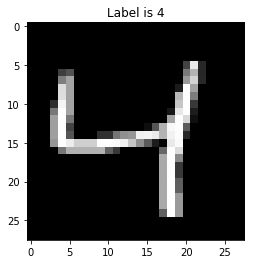

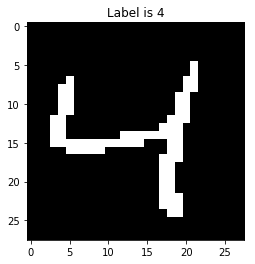

In [21]:
trainingImagesCleaned = thresholdOriginalImages(trainingDataImages)
testImagesCleaned = thresholdOriginalImages(testDataImages)
print(f"Applied threshold to training and test images")
showImage(trainingDataImages[2], trainingLabels[2])
showImage(trainingImagesCleaned[2], trainingLabels[2])

Resizing images to (20, 20)


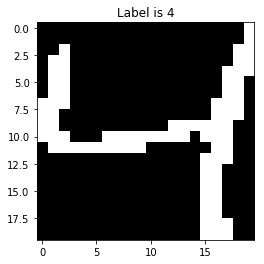

In [22]:
size = (20, 20)
print(f"Resizing images to {size}")
resizedTrainingImages = np.array([np.ravel(thresholdScaledImages(resizeImage(x, size))) for x in trainingDataImages.reshape((-1, 28, 28))])
resizedTestImages = np.array([np.ravel(thresholdScaledImages(resizeImage(x, size))) for x in testDataImages.reshape((-1, 28, 28))])
showImage(resizedTrainingImages[2], trainingLabels[2], size)

## Train Model

### Model 1: Normal distribution with untouched images

Grouping by class
Calculating mean and var


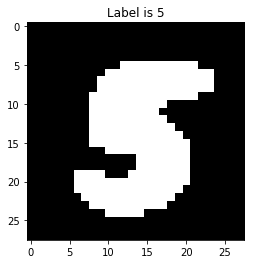

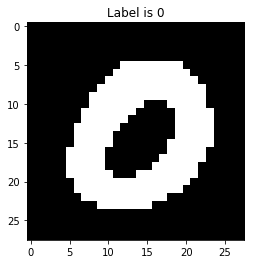

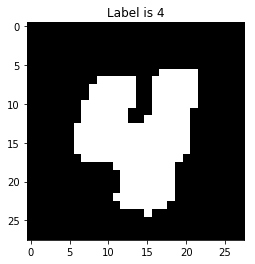

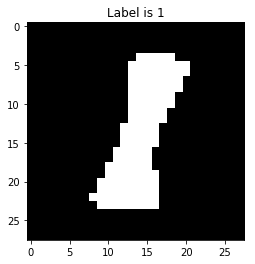

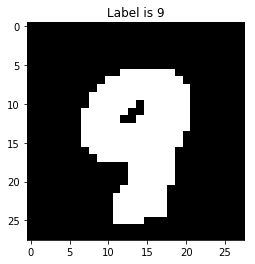

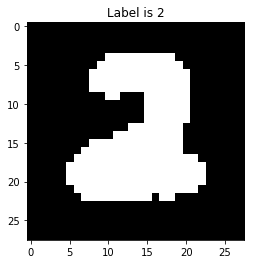

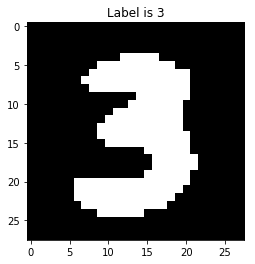

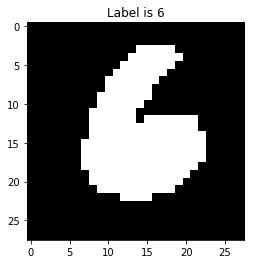

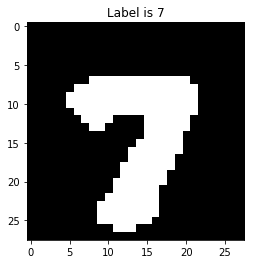

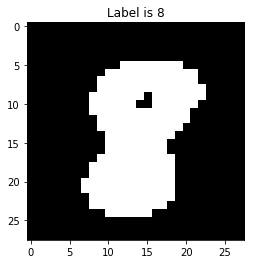

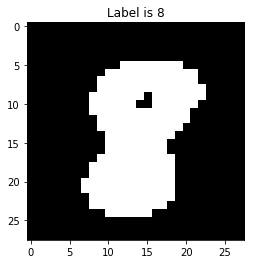

In [73]:
train(trainingImagesCleaned, trainingLabels, testImagesCleaned, testLabels)

### Model 2: Normal distribution with touched images

In [55]:
train(resizedTrainingImages, trainingLabels, resizedTestImages, testLabels)

Grouping by class
Calculating mean and var


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/epino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/epino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
  0%|          | 5/10000 [00:00<03:54, 42.53it/s]

Getting Predictions for test images


  0%|          | 4/60000 [00:00<30:26, 32.85it/s]

Getting Accuracy for test images
Accuracy for test images: 71.89
Getting Predictions for training images


100%|██████████| 60000/60000 [24:11<00:00, 41.33it/s]

Getting Accuracy for training images
Accuracy for training images: 70.70833333333333


(71.89, 70.70833333333333)

### Model 3: Bernoulli distribution with untouched images

https://piazza.com/class/jqo7mhnnyiy698?cid=99
https://piazza.com/class/jqo7mhnnyiy698?cid=189

In [56]:
def countByLabel(labels):
    unique, count = np.unique(labels, return_counts=True)
    return dict(zip(unique, count))

In [57]:
def calculatePdfLog(x, mean):
        if x == 0:
            result = 1 - mean
        else:
            result = mean
        if result == 0.0:
            return 0
        return math.log(result, 10)

In [58]:
def getPredictionForImages(images, means, priors, counts_by_label): 
    predictions = []
    for image in tqdm(images):
        results = []
        for label, counts in counts_by_label.items():
            prior_log = np.log(priors[label])
            posterior_log = np.sum([calculatePdfLog(image[feature], means[label][feature]) for feature in range(len(means[label]))])
            likelyhood = prior_log + posterior_log
            results.append(likelyhood)    
        predictions.append(np.argmax(results))
    return predictions

In [59]:
def calculateBernoulli(images, labels, counts_by_label):
    training_size = len(images)
    label_means = {}
    
    for label, counts in counts_by_label.items():
        sum = np.sum(images[i] if labels[i] == label else 0.0 for i in range(training_size))    
        label_means[label] = sum / counts 
        
    label_prior = {label:(counts/training_size) for label, counts in list(counts_by_label.items())}
    
    return label_means, label_prior

In [60]:
def trainWithBernoulli(trainingImages, trainingLabels, testImages, testLabels):   
    counts_by_label = countByLabel(trainingLabels)
    print("Calculating Bernoulli") 
    label_means, label_prior = calculateBernoulli(trainingImages, trainingLabels, counts_by_label)
    
    print("Getting Predictions for test images")
    predictions = getPredictionForImages(testImages, label_means, label_prior, counts_by_label)
    print("Getting Accuracy for test images")
    test_accuracy =  getAccuracy(predictions, testImages, testLabels)
    print(f"Accuracy for test images: {test_accuracy}")
    
    print("Getting Predictions for training images")
    predictions = getPredictionForImages(trainingImages, label_means, label_prior, counts_by_label)
    print("Getting Accuracy for training images")
    training_accuracy =  getAccuracy(predictions, trainingImages, trainingLabels)
    print(f"Accuracy for training images: {training_accuracy}")
    return accuracy

In [61]:
trainWithBernoulli(trainingImagesCleaned, trainingLabels, testImagesCleaned, testLabels)

/Users/epino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  


Calculating Bernoulli


  0%|          | 16/10000 [00:00<01:03, 156.74it/s]

Getting Predictions for test images


  0%|          | 15/60000 [00:00<06:41, 149.33it/s]

Getting Accuracy for test images
Accuracy for test images: 83.8
Getting Predictions for training images


100%|██████████| 60000/60000 [06:40<00:00, 149.89it/s]

Getting Accuracy for training images
Accuracy for training images: 83.17166666666667


83.17166666666667

### Model 4: Bernoulli distribution with touched images

In [62]:
trainWithBernoulli(resizedTrainingImages, trainingLabels, resizedTestImages, testLabels)

Calculating Bernoulli


/Users/epino/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  
  0%|          | 33/10000 [00:00<00:30, 328.34it/s]

Getting Predictions for test images


  0%|          | 32/60000 [00:00<03:07, 319.48it/s]

Getting Accuracy for test images
Accuracy for test images: 83.83
Getting Predictions for training images


100%|██████████| 60000/60000 [03:14<00:00, 309.28it/s]

Getting Accuracy for training images
Accuracy for training images: 82.49833333333333


82.49833333333333

## Part 2B: MNIST using Decision Forest

## Image Processing

In [63]:
def trainWithRandomForest(trainImages, trainLabels, testImages, testLabels):
    num_of_trees = [10, 30]
    num_of_depths = [4, 16]
    for [tree, depth] in list(product(num_of_trees, num_of_depths)): 
        classifier = RandomForestClassifier(n_estimators=tree, max_depth=depth)
        classifier.fit(trainImages, trainLabels)
        predictions = classifier.predict(testImages)
        test_accuracy =  getAccuracy(predictions, testImages, testLabels)
        print(f"Accuracy for test images: {test_accuracy} using n_estimators={tree} and max_depth={depth}")
        
        predictions = classifier.predict(trainImages)
        training_accuracy =  getAccuracy(predictions, trainImages, trainLabels)
        print(f"Accuracy for training images: {training_accuracy} using n_estimators={tree} and max_depth={depth}")

### Untouched images

In [64]:
trainWithRandomForest(trainingImagesCleaned, trainingLabels, testImagesCleaned, testLabels)

Accuracy for test images: 68.19 using n_estimators=10 and max_depth=4
Accuracy for training images: 67.42333333333333 using n_estimators=10 and max_depth=4
Accuracy for test images: 93.66 using n_estimators=10 and max_depth=16
Accuracy for training images: 98.95833333333334 using n_estimators=10 and max_depth=16
Accuracy for test images: 74.32 using n_estimators=30 and max_depth=4
Accuracy for training images: 73.45833333333334 using n_estimators=30 and max_depth=4
Accuracy for test images: 95.76 using n_estimators=30 and max_depth=16
Accuracy for training images: 99.39166666666667 using n_estimators=30 and max_depth=16


### Touched images

In [65]:
trainWithRandomForest(resizedTrainingImages, trainingLabels, resizedTestImages, testLabels)

Accuracy for test images: 73.37 using n_estimators=10 and max_depth=4
Accuracy for training images: 72.5 using n_estimators=10 and max_depth=4
Accuracy for test images: 95.47 using n_estimators=10 and max_depth=16
Accuracy for training images: 99.53999999999999 using n_estimators=10 and max_depth=16
Accuracy for test images: 75.1 using n_estimators=30 and max_depth=4
Accuracy for training images: 73.94 using n_estimators=30 and max_depth=4
Accuracy for test images: 96.85000000000001 using n_estimators=30 and max_depth=16
Accuracy for training images: 99.69166666666666 using n_estimators=30 and max_depth=16
